In [269]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
import math
import random
import numpy as np
from numpy import pi
import time
import itertools
import matplotlib.pyplot as plt


In [8]:
def prepare_initial_state(theta, phase):
    """ Prepare initial state """
    return (math.cos(theta / 2) * (1 + 0j),
        (math.sin(theta / 2) * math.e**(1j * phase) + 0 + 0j))

In [9]:
def convert_counts_to_final_state(counts):
    """ Convert the results of a simulation to a final state: aplha*|0> + beta*|1> """
    counts_zero = 0
    counts_one = 0

    if "0" in counts:
        counts_zero = counts["0"]
    if "1" in counts:
        counts_one = counts["1"]

    total_cycles = counts_zero + counts_one

    return (np.sqrt(counts_zero / total_cycles),
            np.sqrt(counts_one / total_cycles))

In [10]:
def set_random_eta(eta0, eta1):
    """ return a random choice from eta0 and eta1 with the correspondent key name """
    eta_value = random.choice([eta0, eta1])
    if eta_value == eta0:
        return eta_value, 0
    return eta_value, 1

In [11]:
def compute_damping_channel(theta, phase, eta, phi_rx, phi_ry, backend, iterations=1024):
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')

    initial_state = prepare_initial_state(theta, phase)

    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([initial_state[0],
                        initial_state[1]], qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.cry(eta, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rx(phi_rx, qreg_q[0])
    circuit.ry(phi_ry, qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])

    counts = execute(circuit, backend, shots=iterations).result().get_counts(circuit)
    return convert_counts_to_final_state(counts)

In [12]:
def compute_random_damping_channel(configuration, backend, iterations=1024):
    eta_value, eta_used = set_random_eta(configuration['eta0'], configuration['eta1'])
    result = compute_damping_channel(configuration['theta'], configuration['phase'], eta_value, configuration['phi_rx'], configuration['phi_ry'], backend, iterations)

    return {
        "0": result[0],
        "1": result[1],
        "eta_used": eta_used
    }

## A sample execution

In [13]:
# a simple execution
backend = backend=Aer.get_backend('qasm_simulator')

theta = pi
phase = pi
phi_rx = 0
phi_ry = 0
eta0 = pi/2
eta1 = 0

configuration = {
    "theta": theta,
    "phase": phase,
    "phi_rx": phi_rx,
    "phi_ry": phi_ry,
    "eta0": eta0,
    "eta1": eta1
}

In [14]:
real_result = compute_random_damping_channel(configuration, backend)
real_result

{'0': 0.7194290270763336, '1': 0.6945659615904022, 'eta_used': 0}

In [19]:
def guess_eta_used(real_result, configuration, backend, iterations=1024):
    """ function to decide which eta was used on the real random execution and return 0 or 1 as the eta index """
    execution_eta0 = compute_damping_channel(configuration['theta'], configuration['phase'], configuration['eta0'], configuration['phi_rx'], configuration['phi_ry'], backend, iterations)
    # execution_eta1 = compute_damping_channel(configuration['theta'], configuration['phase'], configuration['eta1'], configuration['phi_rx'], configuration['phi_ry'], backend, iterations)

    # !!! TODO decide how to better check that
    # now just comparing if the values rounded to two decimasls are equal to the first execution
    if (np.round(execution_eta0[0]) == np.round(real_result["0"]) and 
        np.round(execution_eta0[1]) == np.round(real_result["1"])):
        return 0
    return 1

In [16]:
def check_value(real_eta, guess_eta): 
    if real_eta == guess_eta: return 1
    return 0

In [20]:
guess_eta_used(real_result, configuration, backend)

0

In [21]:
def play_and_guess_one_case(configuration, backend, iterations=1024):
    """ Execute a real execution with a random eta from the two passed, 
        guess which one was used on the exection and
        check the result.
        Returns 1 on success (it was a correct guess) or 0 on fail (it was an incorrect guess) 
    """
    real_result = compute_random_damping_channel(configuration, backend)
    guess_eta = guess_eta_used(real_result, configuration, backend)
    return check_value(real_result['eta_used'], guess_eta)

In [22]:
configuration = {
    "theta": theta,
    "phase": phase,
    "phi_rx": phi_rx,
    "phi_ry": phi_ry,
    "eta0": eta0,
    "eta1": eta1
}
play_and_guess_one_case(configuration, backend)

1

## Launching the loop to determine the best combination to detect the given $\eta$

In [240]:
def play_and_guess(global_configuration, backend, plays=10, simulation_iterations=1024):
    """ Play the play_and_guess game for the number of plays for each combination of input parameters.
        Returns an array of execution results. 

        Each item of the result list consist of:
        -----------------------------------------------------------------
        | theta | phase | phi_rx | phi_ry | eta0 | eta1 | succ_avg_prob |
        -----------------------------------------------------------------
        succ_avg_prob: is the average probability of guessing correctly for this specific combination 
        We want to maximize these value.
    """
    results = []
    list_theta = global_configuration['list_theta']
    list_phase = global_configuration['list_phase']
    list_phi_rx = global_configuration['list_phi_rx']
    list_phi_ry = global_configuration['list_phi_ry']
    list_eta = global_configuration['list_eta']
    
    # when there is only one element, we add the same element
    if len(list_eta) == 1:
        list_eta.append(list_eta[0])
    # get combinations of two etas without repeats
    two_pair_etas = list(itertools.combinations(list_eta, 2))

    program_start_time = time.time()
    print("Starting the execution")
    i = 0
    for theta in list_theta:
        print(f"execution with theta {theta}")
        start_time = time.time()
        for phase in list_phase:
            for phi_rx in list_phi_rx:
                for phi_ry in list_phi_ry:
                    for eta_pair in two_pair_etas:

                        configuration = {
                            "theta": theta,
                            "phase": phase,
                            "phi_rx": phi_rx,
                            "phi_ry": phi_ry,
                            "eta0": eta_pair[0],
                            "eta1": eta_pair[1]
                        }

                        success_counts = 0
                        for play in range(plays):
                            success_counts += play_and_guess_one_case(configuration, backend, simulation_iterations)
                        succ_avg_prob = success_counts/plays
                        results.append({
                            "theta": theta,
                            "phase": phase,
                            "phi_rx": phi_rx,
                            "phi_ry": phi_ry,
                            "eta0": eta_pair[0],
                            "eta1": eta_pair[1],
                            "succ_avg_prob": succ_avg_prob
                        })
                        i+=1
        end_time = time.time()
        print("total minutes taken this theta: ", int(np.round((end_time - start_time)/60)))
        print("total minutes taken so far: ", int(np.round((end_time - program_start_time)/60)))
    end_time = time.time()
    print("total minutes of execution time: ", int(np.round((end_time - program_start_time)/60)))
    print("All guesses have been calculated")
    print(f"Total executions: {i} ")
    return results

### Set a list of configurations to play: a simple one

In [241]:
global_configuration = {
    'list_theta': [0],
    'list_phase': [0],
    'list_phi_rx': [0],
    'list_phi_ry': [0],
    'list_eta': [0,0],
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
simulation_iterations = 1024

In [242]:
play_and_guess(global_configuration, backend, plays, simulation_iterations)

Starting the execution
execution with theta 0
total minutes taken this theta:  0
total minutes taken so far:  0
total minutes of execution time:  0
All guesses have been calculated
Total executions: 1 


[{'theta': 0,
  'phase': 0,
  'phi_rx': 0,
  'phi_ry': 0,
  'eta0': 0,
  'eta1': 0,
  'succ_avg_prob': 1.0}]

### Set a list of configurations to play: with more options

In [243]:
points_theta=5
points_phase=5
list_theta = np.mgrid[0:pi:points_theta * 1j]
list_phase = np.mgrid[0:2 * pi:points_phase * 1j]
list_eta = [0, pi/2, pi/1.5]
list_phi_rx = [0]
list_phi_ry = [0]

global_configuration2 = {
    'list_theta': list_theta,
    'list_phase': list_phase,
    'list_phi_rx': list_phi_rx,
    'list_phi_ry': list_phi_ry,
    'list_eta': list_eta,
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
simulation_iterations = 1024

In [244]:
results = play_and_guess(global_configuration2, backend, plays, simulation_iterations)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 0.7853981633974483
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 1.5707963267948966
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 2.356194490192345
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 3.141592653589793
total minutes taken this theta:  0
total minutes taken so far:  0
total minutes of execution time:  0
All guesses have been calculated
Total executions: 75 


In [248]:
results[1]

{'theta': 0.0,
 'phase': 0.0,
 'phi_rx': 0,
 'phi_ry': 0,
 'eta0': 0,
 'eta1': 2.0943951023931953,
 'succ_avg_prob': 0.4}

In [251]:
def set_result_with_etas_and_psuccess(results):
    eta_pairs = []
    p_success = []

    for result in results:
        eta_pairs.append(str(int(math.degrees(result['eta0']))) + ' ' + str(int(math.degrees(result['eta1']))))
        p_success.append(result['succ_avg_prob'])
    return {
        'eta_pairs': eta_pairs,
        'p_success': p_success
    }

In [257]:
to_print = set_result_with_etas_and_psuccess(results)

In [260]:
def set_result_with_initial_states_and_psuccess(results):
    initial_states = []
    p_success = []

    for result in results:
        initial_states.append(str(int(math.degrees(result['theta']))) + ' ' + str(int(math.degrees(result['phase']))))
        p_success.append(result['succ_avg_prob'])
    return {
        'initial_states': initial_states,
        'p_success': p_success
    }

In [261]:
to_print = set_result_with_initial_states_and_psuccess(results)

In [285]:
def plot_scatter(X, Y, x_label):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle('Probability Analysis', fontsize=20)
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Prob. Success')
    ax1.scatter(X, Y)
    plt.show()

In [283]:
points_theta=5
points_phase=5
list_theta = np.mgrid[0:pi:points_theta * 1j]
list_phase = np.mgrid[0:2 * pi:points_phase * 1j]
list_eta = [0]
list_phi_rx = [0]
list_phi_ry = [0]

global_configuration = {
    'list_theta': list_theta,
    'list_phase': list_phase,
    'list_phi_rx': list_phi_rx,
    'list_phi_ry': list_phi_ry,
    'list_eta': list_eta,
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
simulation_iterations = 1024
results = play_and_guess(global_configuration, backend, plays, simulation_iterations)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 0.7853981633974483
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 1.5707963267948966
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 2.356194490192345
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 3.141592653589793
total minutes taken this theta:  0
total minutes taken so far:  0
total minutes of execution time:  0
All guesses have been calculated
Total executions: 25 


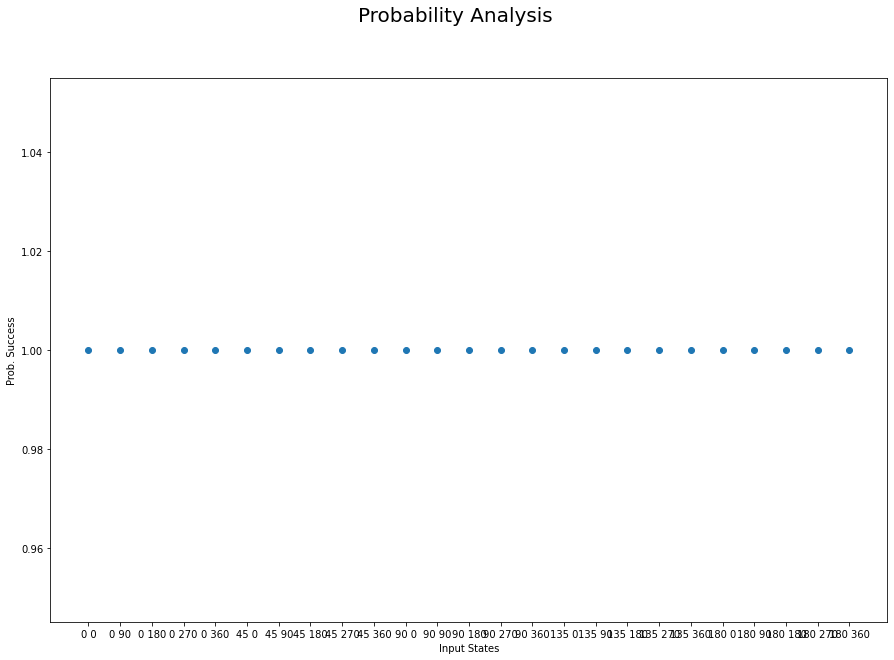

In [286]:
to_print = set_result_with_initial_states_and_psuccess(results)
plot_scatter(to_print['initial_states'], to_print['p_success'], 'Input States')

In [287]:
points_theta=5
points_phase=5
list_theta = np.mgrid[0:pi:points_theta * 1j]
list_phase = np.mgrid[0:2 * pi:points_phase * 1j]
list_eta = [0, pi/4/2]
list_phi_rx = [0]
list_phi_ry = [0]

global_configuration = {
    'list_theta': list_theta,
    'list_phase': list_phase,
    'list_phi_rx': list_phi_rx,
    'list_phi_ry': list_phi_ry,
    'list_eta': list_eta,
}

backend = Aer.get_backend('qasm_simulator')
plays = 10
simulation_iterations = 1024
results = play_and_guess(global_configuration, backend, plays, simulation_iterations)

Starting the execution
execution with theta 0.0
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 0.7853981633974483
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 1.5707963267948966
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 2.356194490192345
total minutes taken this theta:  0
total minutes taken so far:  0
execution with theta 3.141592653589793
total minutes taken this theta:  0
total minutes taken so far:  0
total minutes of execution time:  0
All guesses have been calculated
Total executions: 25 


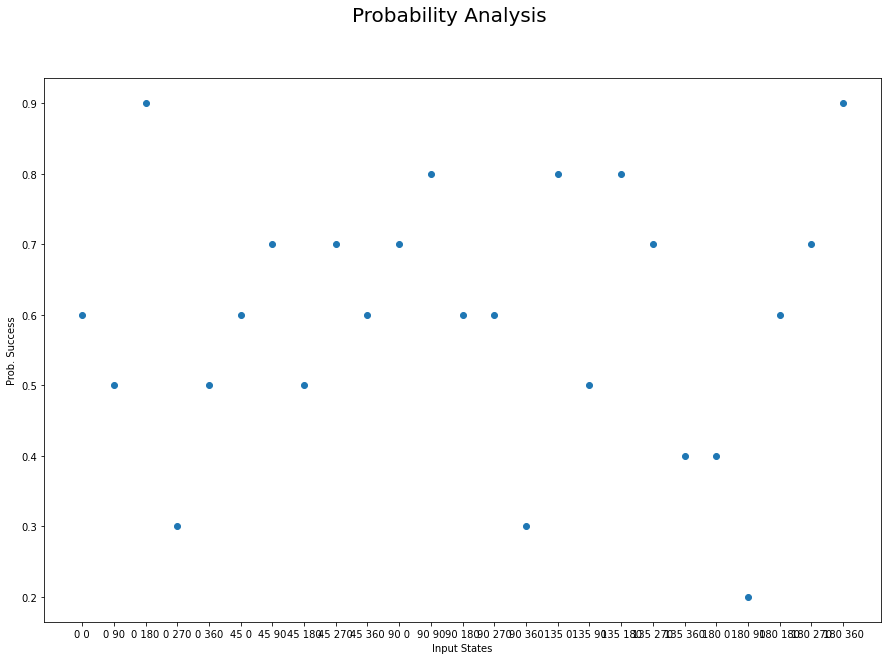

In [288]:
to_print = set_result_with_initial_states_and_psuccess(results)
plot_scatter(to_print['initial_states'], to_print['p_success'], 'Input States')